In [2]:
# Code thanks to Moses Boudourides, Sergios Lenis & Pantelis Vikatos
# Their version (largely unchanged except for fixing some python 3.5 incompatibilities)
# can be seen here: http://mboudour.github.io/2016/03/22/Clinton-Sanders-Word-Nets.html
import nltk
import os
import re
import itertools
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import codecs
from textblob import TextBlob
import pandas as pd
import re
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Open and read transcripts in NLTK
f1=codecs.open('../../../private/brainstorming_viz_data/free_group/teamA_part1_divergent.txt', 'r', encoding='utf-8')
f2=codecs.open('../../../private/brainstorming_viz_data/free_group/teamA_part2_convergent.txt', 'r', encoding='utf-8')
f1Temp = codecs.open('tempASCII', 'w', encoding='ascii', errors='ignore')
f2Temp = codecs.open('tempASCII', 'w', encoding='ascii', errors='ignore')
f1Temp.write('free_group/teamA_part1_divergent_bak.txt')
f2Temp.write('free_group/teamA_part1_convergent_bak.txt')
divergent_raw = f1.read()
convergent_raw = f2.read()
regex = re.compile(".*?\\[(.*?)\\]")

def removeObservations(test_str):
    # removes all text within parantheses
    # these are usually observations by the transcriber
    # and thus should not be considered in content analysis
    # code from http://stackoverflow.com/questions/14596884/remove-text-between-and-in-python
    ret = ''
    skip1c = 0
    skip2c = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    return ret

divergent = removeObservations(divergent_raw)
convergent = removeObservations(convergent_raw)

In [4]:
# Extract Noun phrases using TextBlob
blobDivergent = TextBlob(divergent)
blobConvergent = TextBlob(convergent)
nounDiv = blobDivergent.np_counts
nounConv = blobConvergent.np_counts
dfnp1 = pd.DataFrame(columns=['Noun phrases in Divergent phase', 'Frequencies'])
dfnp2 = pd.DataFrame(columns=['Noun phrases in Convergent phase', 'Frequencies'])
u=1
for i in nounDiv:
    dfnp1.loc[u] = [i, nounDiv[i]]
    u+=1

u=1
for i in nounConv:
    dfnp2.loc[u] = [i, nounConv[i]]
    u+=1
    
print("The total number of noun phrases in the divergent phase:", len(nounDiv))
dfnp1.head(15)

The total number of noun phrases in the divergent phase: 221


,Noun phrases in Divergent phase,Frequencies
1,rangers,1
2,projectile guns,2
3,electronic game,1
4,it’d,1
5,say,1
6,football machine,1
7,underwater bicycle guy,1
8,explain,1
9,swivel,1
10,roommate freshman year,1


In [5]:
print("The total number of noun phrases in the convergent phase:", len(nounConv))
dfnp2.head(15)

The total number of noun phrases in the convergent phase: 104


,Noun phrases in Convergent phase,Frequencies
1,ta draw,1
2,like—i don’t,1
3,wheelchair shooting,1
4,here’s,1
5,say,1
6,cleaning,1
7,i’m,5
8,can’t,2
9,one’s gon na,1
10,pincers,1


In [6]:
# Common noun phrases in both phases
common = {}
notcommon = {}
dfc = pd.DataFrame(columns=["Common noun phrases", "Divergent", "Convergent"])
u=1
for i in nounDiv:
    if i in nounConv:
        common[i] = min(nounDiv[i], nounConv[i])
        notcommon[i] = (nounDiv[i], nounConv[i])
        dfc.loc[u] = [i, nounDiv[i], nounConv[i]]
        u+=1
dfc

,Common noun phrases,Divergent,Convergent
1,say,1,1
2,cool,1,1
3,rc,3,1
4,i’ll,1,2
5,good idea,3,1
6,okay,10,2
7,let’s,3,1
8,gon na,3,4
9,have,2,2
10,it’s,8,2


In [7]:
# Noun phrases that can be removed:
to_be_removed = [u'okay', u'yeah']
keys_to_delete = []
for key in common.keys():
    if key in to_be_removed:
        keys_to_delete.append(key)
for key in keys_to_delete:
    del common[key] # could not have deleted item from iterable 
                    # from within the loop
ccommon=common.keys()

In [8]:
# Function to count co-occurrences of common noun phrases in sentences
def occurrences(source, terms):
    ALL_sentences=sent_tokenize(source) # creates a list of sentences
    combinations_terms = list(itertools.combinations(terms,2)) # NC2 of terms
    n = len(combinations_terms)
    occurlist = []
    for i in range(1, n):
        for j in ALL_sentences:
            temp = list(combinations_terms[i])
            # Find every combination of term 1 followed by term 2 in
            # term pair (1,2)
            out=re.compile(str(temp[0]) + '(.*?)' + str(temp[1]), 
                           re.DOTALL | re.IGNORECASE).findall(j)
            if out:
                occurlist.append(str(temp[0]) + ' - ' + str(temp[1]))
            # Find every combination of term 2 followed by term 1 in
            # term pair (1,2)
            out2 = re.compile(str(temp[1]) + '(.*?)' + str(temp[0]),
                             re.DOTALL | re.IGNORECASE).findall(j)
            if out2:
                occurlist.append(str(temp[1]) + ' - ' + str(temp[0]))
    occurdict = {}
    # count occurrences of term pairs
    for i in occurlist:
        if i not in occurdict:
            occurdict[i] = 1
        else : 
            occurdict[i] = occurdict[i] + 1
    return occurdict

# Call function to find divergent and convergent terms
Divdict = occurrences(divergent, ccommon)
Convdict = occurrences(convergent, ccommon)
# nounDivdict = dict(nounDiv)
# nounConvdict = dict(nounConv)
# Divdict = occurrences(divergent, nounDiv)
# Convdict = occurrences(convergent, nounConv)

In [9]:
# Function to construct a graph of common noun phrases tied by 
# their co-occurrences in sentences of a transcript
def makegraph(occurrences):
    G = nx.Graph()
    weights = []
    for edgs,wt in occurrences.items():
        edg = edgs.split(' - ')
        G.add_edge(edg[0], edg[1], weight=wt)
        G.add_node(edg[0], label=edg[0])
        G.add_node(edg[1], label=edg[1])
        weights.append(wt)
    return [G, weights]

DivGraphData = makegraph(Divdict)
ConvGraphData = makegraph(Convdict)
GDiv = DivGraphData[0]
GConv = ConvGraphData[0]
DivEdges = DivGraphData[1]
ConvEdges = ConvGraphData[1]

In [10]:
print(GDiv.edges(data=True))

[('say', 'have', {'weight': 1}), ('mechanical motion', 'have', {'weight': 1}), ('rc', 'have', {'weight': 1}), ('that’s', 'have', {'weight': 1}), ('that’s', 'here’s', {'weight': 1}), ('that’s', 'right', {'weight': 1}), ('that’s', 'cool', {'weight': 1}), ('that’s', 'good idea', {'weight': 2}), ('that’s', 'it’s', {'weight': 1}), ('have', 'right', {'weight': 1}), ('have', 'shoots', {'weight': 1}), ('here’s', 'right', {'weight': 1}), ('right', 'shoots', {'weight': 1}), ('right', 'it’s', {'weight': 1}), ('good idea', 'it’s', {'weight': 1})]


In [11]:
print(GConv.edges(data=True))

[('i’m', 'have', {'weight': 3}), ('i’m', 'it’s', {'weight': 1}), ('whole thing', 'have', {'weight': 1}), ('rc', 'it’s', {'weight': 1}), ('that’s', 'right', {'weight': 1}), ('that’s', 'say', {'weight': 1}), ('have', 'say', {'weight': 1}), ('have', 'it’s', {'weight': 1}), ('have', 'here’s', {'weight': 1})]


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


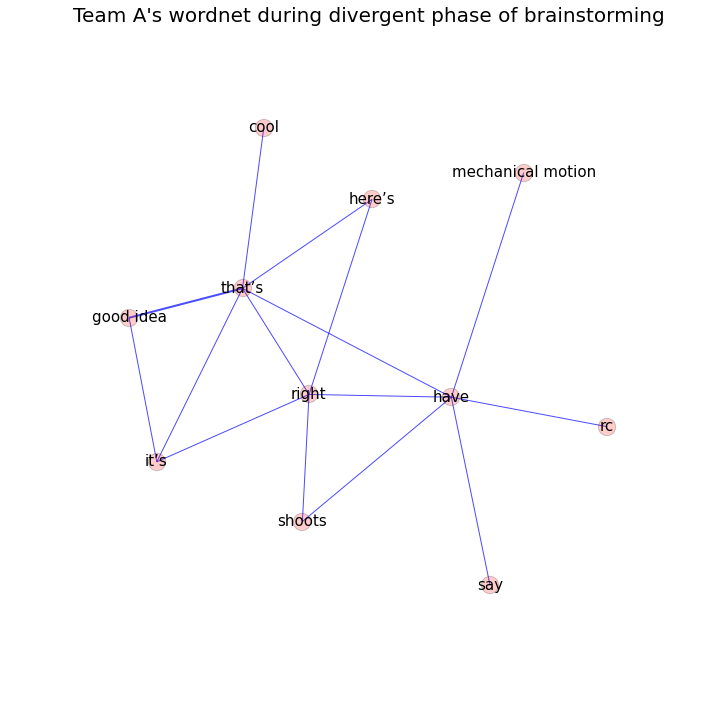

In [12]:
# Plot graph of common phrases in Team A's divergent phase
from tools import draw_network
pos = nx.spring_layout(GDiv, iterations=20)
sstt="Team A's wordnet during divergent phase of brainstorming"
possit=draw_network(GDiv,sstt,pos=pos,with_edgewidth=True,withLabels=True,
                    labfs=15,valpha=0.2,ealpha=0.7,labelfont=15)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


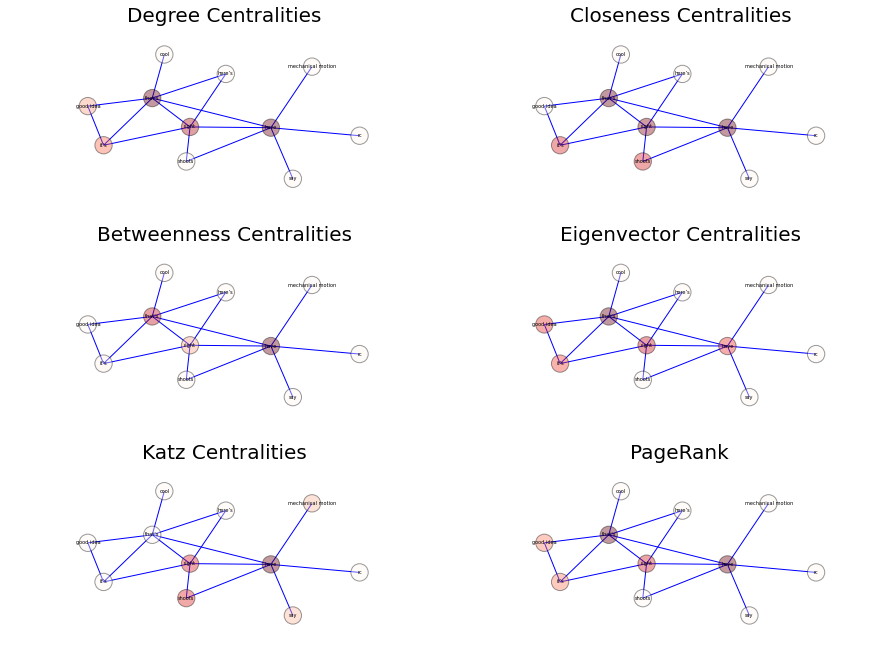

In [13]:
# Compute centralities of cmmon phrases in the graph of the divergent process

from tools import draw_centralities_subplots
centrali=draw_centralities_subplots(GDiv, pos, withLabels=True,labfs=5,
                                   figsi=(15, 15), ealpha=1, vals=True)

In [14]:
# Table of centralities of common phrases in the graph
dfcdiv = pd.DataFrame()
# The rest needs to be sorted out; version incompatibility

Number of communities of  Team A's wordnet during divergent phase of brainstorming  =  3
Community partition of  Team A's wordnet during divergent phase of brainstorming :
[['mechanical motion', 'rc', 'say', 'have'], ['that’s', 'it’s', 'cool', 'good idea'], ['here’s', 'right', 'shoots']]
Community modularity of Team A's wordnet during divergent phase of brainstorming  =  0.275390625


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


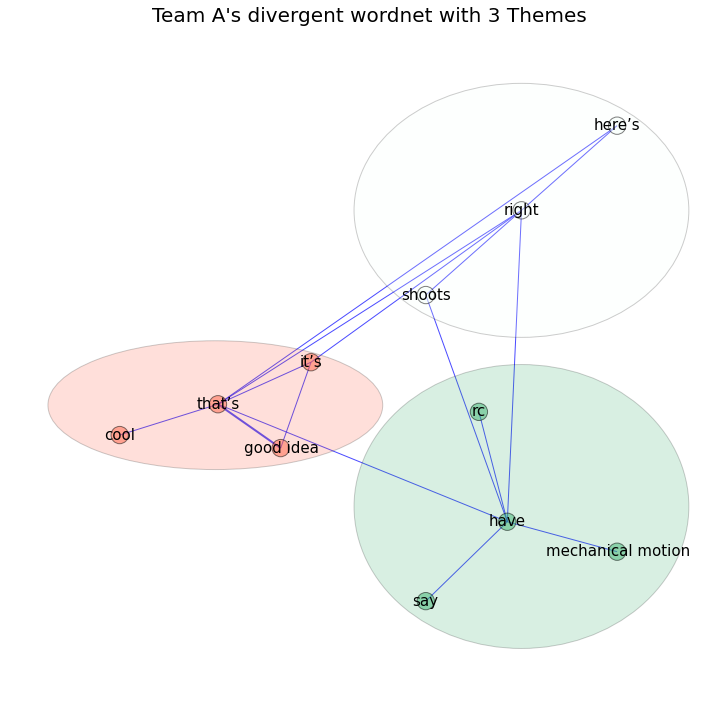

In [15]:
# detecting communities of common phrases
%autoreload 2
from tools import draw_comms, modul_arity, print_communities
part, nodper = print_communities(GDiv, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=.7
vcc={}

sstta="Team A's divergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GDiv,GDiv.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=15,valpha=0.5)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


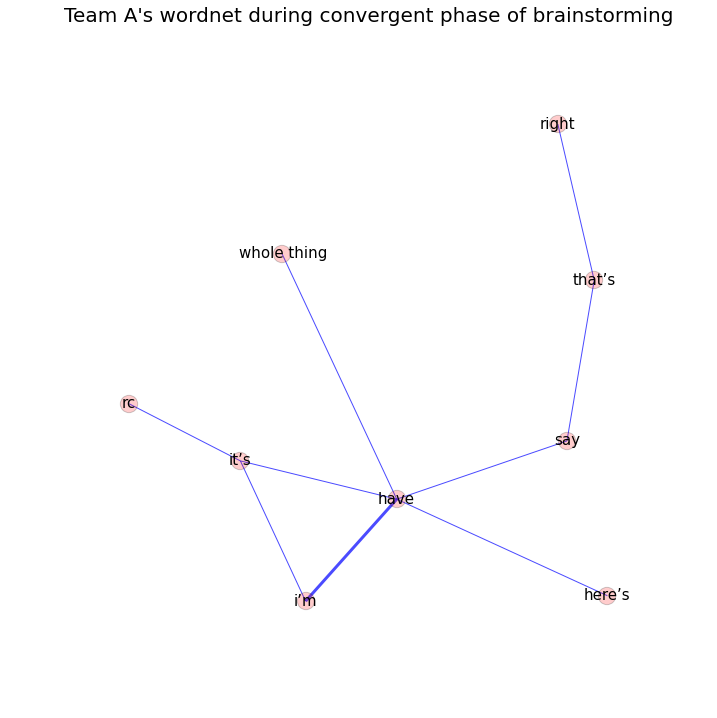

In [16]:
# Plot graph of common phrases in Team A's convergent phase
from tools import draw_network
pos = nx.spring_layout(GConv, iterations=20)
sstt="Team A's wordnet during convergent phase of brainstorming"
possit=draw_network(GConv,sstt,pos=pos,with_edgewidth=True,withLabels=True,
                    labfs=15,valpha=0.2,ealpha=0.7,labelfont=15)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


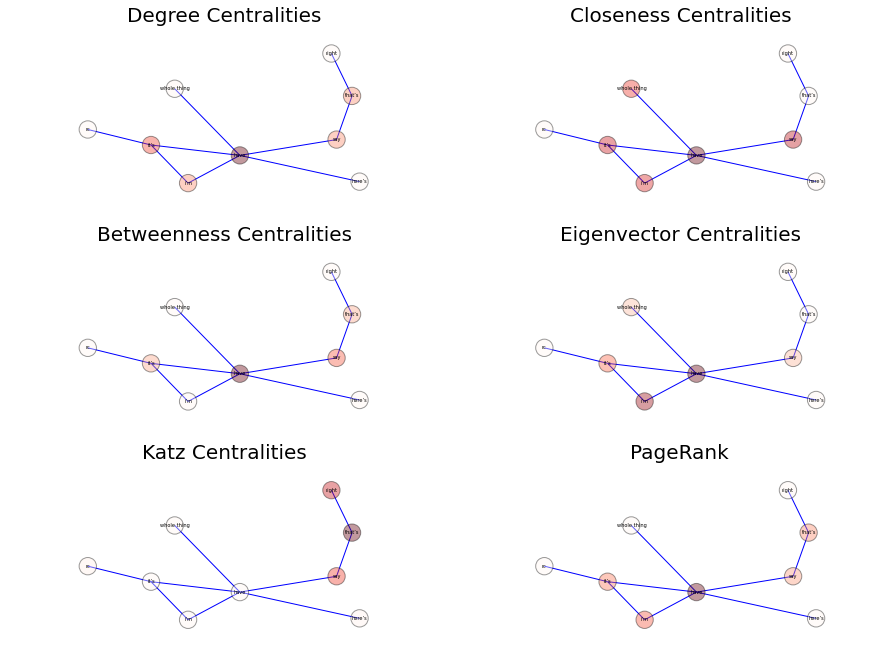

In [17]:
# Compute centralities of cmmon phrases in the graph of the divergent process

from tools import draw_centralities_subplots
centrali=draw_centralities_subplots(GConv, pos, withLabels=True,labfs=5,
                                   figsi=(15, 15), ealpha=1, vals=True)

Number of communities of  Team A's wordnet during convergent phase of brainstorming  =  3
Community partition of  Team A's wordnet during convergent phase of brainstorming :
[['i’m', 'here’s', 'whole thing', 'have'], ['rc', 'it’s'], ['that’s', 'say', 'right']]
Community modularity of Team A's wordnet during convergent phase of brainstorming  =  0.293388429752066


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


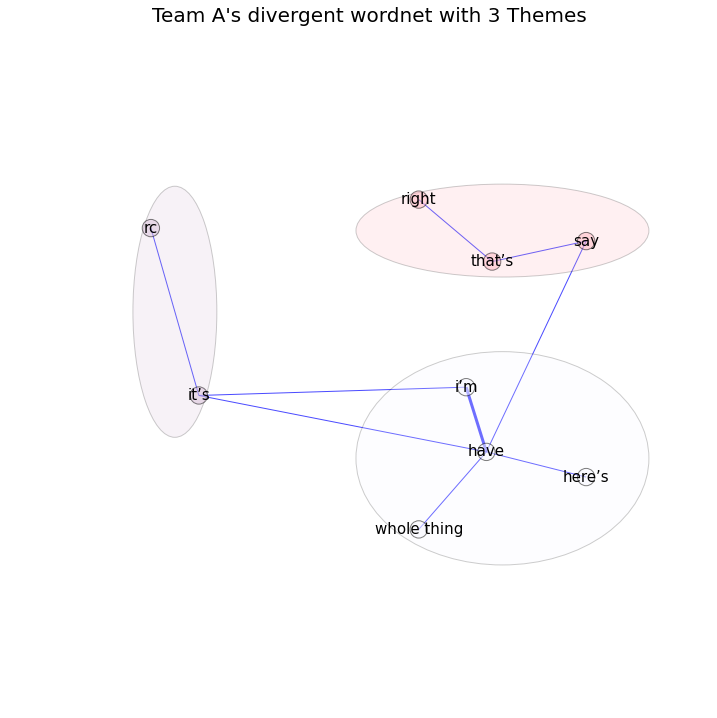

In [18]:
# detecting communities of common phrases
%autoreload 2
from tools import draw_comms, modul_arity, print_communities
part, nodper = print_communities(GConv, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=.7
vcc={}

sstta="Team A's divergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GConv,GConv.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=15,valpha=0.5)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


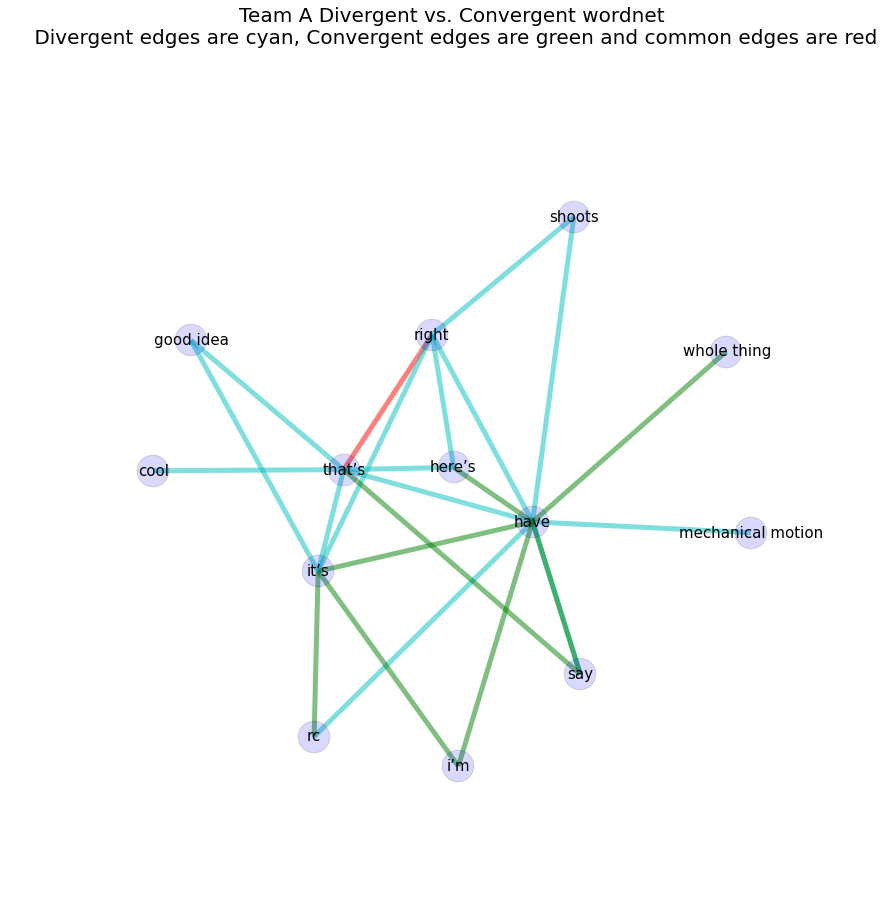

In [19]:
# Plotting the Hillary Clinton vs. Bernie Sanders wordnet

G = nx.Graph()
G.add_edges_from(GDiv.edges())
G.add_edges_from(GConv.edges())
pos=nx.spring_layout(G)
# pos=nx.spring_layout(G)
sstt="Team A Divergent vs. Convergent wordnet \n Divergent edges are cyan, Convergent edges are green and common edges are red"
plt.figure(figsize=(15,15))
common_edges=set(GDiv.edges()).intersection(set(GConv.edges()))
HCandBSedges = list(common_edges)
Cedges=set(GDiv.edges()).difference(set(GConv.edges()))
HCedges = list(Cedges)
Sedges=set(GConv.edges()).difference(set(GDiv.edges()))
BSedges = list(Sedges)
nx.draw_networkx_nodes(G,pos,withLabels=True,node_color='b',node_size=1000,alpha=0.15)
nx.draw_networkx_edges(G,pos,edgelist=HCandBSedges,width=5,alpha=0.5,edge_color='r')
nx.draw_networkx_edges(G,pos,edgelist=HCedges,width=5,alpha=0.5,edge_color='c')
nx.draw_networkx_edges(G,pos,edgelist=BSedges,width=5,alpha=0.5,edge_color='g')
nx.draw_networkx_labels(G,pos=pos,font_size=15)
plt.title(sstt,fontsize=20)
kk=plt.axis('off')